Analyse the forward pass and backward pass of back propagation algorithm for the network using your own initiate, forward, backward and loss functions . use pytorch

100%|██████████| 170498071/170498071 [00:04<00:00, 41981257.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/5], Forward Pass Loss: 5.4185, Backward Pass Loss: 4.5098
Epoch [2/5], Forward Pass Loss: 2.4440, Backward Pass Loss: 2.7457
Epoch [3/5], Forward Pass Loss: 0.5288, Backward Pass Loss: 0.4527
Epoch [4/5], Forward Pass Loss: 0.3177, Backward Pass Loss: 0.2793
Epoch [5/5], Forward Pass Loss: 0.2352, Backward Pass Loss: 0.2099


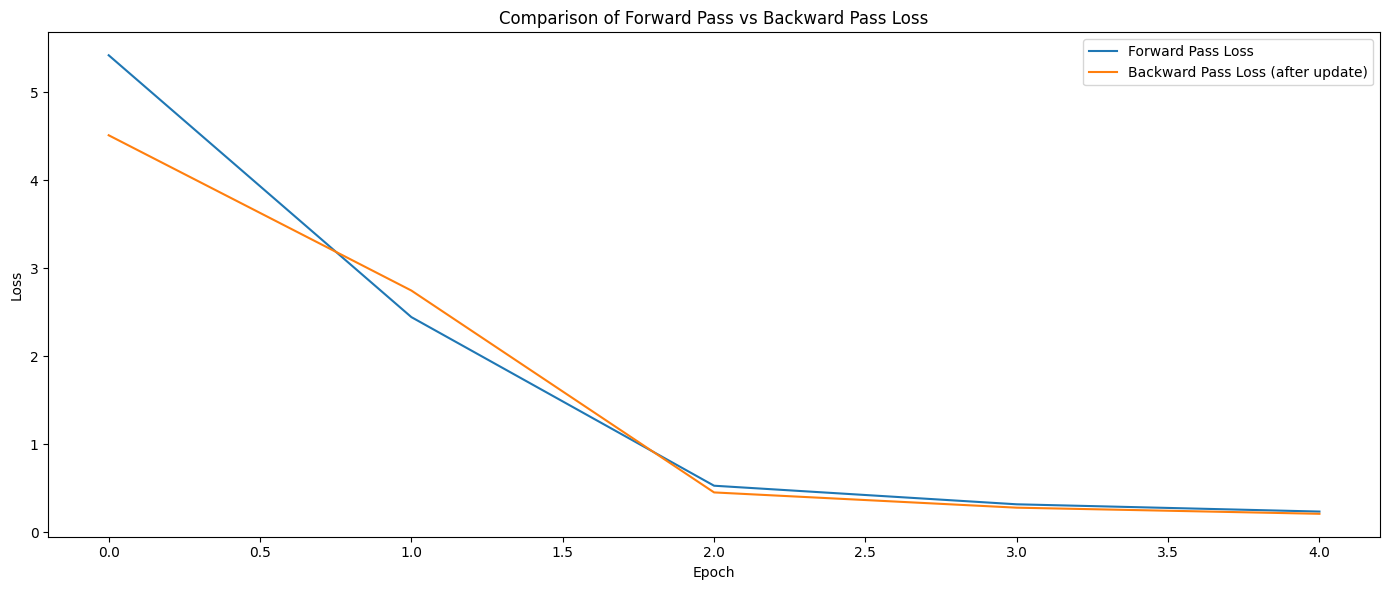

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt

# Step 1: Define transformations and load the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download CIFAR-10 dataset and filter for cats (label 3) and dogs (label 5)
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter CIFAR-10 to only include cats and dogs, and limit the number of samples
def filter_and_reduce(dataset, limit=100):
    cats_dogs = []
    count = [0, 0]  # [cats, dogs]
    for img, label in dataset:
        if label == 3 and count[0] < limit // 2:
            cats_dogs.append((img, 0))  # 0 for cats
            count[0] += 1
        elif label == 5 and count[1] < limit // 2:
            cats_dogs.append((img, 1))  # 1 for dogs
            count[1] += 1
        if sum(count) >= limit:
            break
    return cats_dogs

train_data = filter_and_reduce(cifar10_train, limit=200)
train_loader = data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)

# Step 2: Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 128 * 128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.sigmoid(self.fc1(x))
        return x

# Step 3: Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training loop comparing Forward and Backward Passes
num_epochs = 5
forward_pass_losses = []
backward_pass_losses = []

for epoch in range(num_epochs):
    model.train()

    running_loss_forward = 0.0
    running_loss_backward = 0.0

    for inputs, labels in train_loader:
        labels = labels.view(-1, 1).float()

        # Forward pass only (before updating weights)
        outputs = model(inputs)
        forward_loss = criterion(outputs, labels)
        running_loss_forward += forward_loss.item() * inputs.size(0)

        # Now do the backward pass and update weights
        optimizer.zero_grad()
        forward_loss.backward()  # Use the same loss to compute gradients
        optimizer.step()

        # After updating weights, compute the new loss
        outputs_after_update = model(inputs)
        backward_loss = criterion(outputs_after_update, labels)
        running_loss_backward += backward_loss.item() * inputs.size(0)

    forward_pass_loss = running_loss_forward / len(train_loader.dataset)
    backward_pass_loss = running_loss_backward / len(train_loader.dataset)

    forward_pass_losses.append(forward_pass_loss)
    backward_pass_losses.append(backward_pass_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Forward Pass Loss: {forward_pass_loss:.4f}, Backward Pass Loss: {backward_pass_loss:.4f}')

# Step 5: Plotting the results for comparison
plt.figure(figsize=(14, 6))

# Plot Loss for Forward Pass vs Backward Pass
plt.plot(forward_pass_losses, label='Forward Pass Loss')
plt.plot(backward_pass_losses, label='Backward Pass Loss (after update)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Forward Pass vs Backward Pass Loss')
plt.legend()

plt.tight_layout()
plt.show()
